In [14]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf data/
!tar -xf "/content/drive/MyDrive/Academics/Courses/Machine Learning/HW4/data.tar.gz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

from scipy.special import gamma, factorial
from data.FACES.imageLoader import loadImages

import tensorflow as tf

import multiprocessing as mp


import matplotlib.pyplot as plt

In [ ]:
class AssignmentUtils:
    def __init__(self):
        self.data_path = "data"

    def load_mnist(self, prefix, reduced=False):
        folder_name = "Reduced Fashion-MNIST" if reduced else "Fashion-MNIST"
        image_pattern = "{}_Data.csv" if reduced else "{}Data.csv"
        label_pattern = "{}_Labels.csv"if reduced else "{}Labels.csv"
        prefix = prefix.capitalize() if reduced else prefix.lower()
        
        image_loc = os.path.join(self.data_path, 
                                folder_name,
                                image_pattern.format(prefix))
                                
        label_loc = os.path.join(self.data_path, 
                                folder_name,
                                label_pattern.format(prefix))
             
        image_df = pd.read_csv(image_loc, index_col=False, header=None)
        labels_df = pd.read_csv(label_loc, index_col=False, header=None)
        images = image_df.to_numpy()
        labels = [l for l in labels_df[0]]
        

        data_df = pd.DataFrame([
                                {
                                    "image": im,
                                    "label": l
                                } for im, l in zip(images, labels)
        ])
        return data_df
            
    def load_faces(self, prefix_type):
        folder = os.path.join(self.data, "FACES", prefix_type)
        return loadImages(folder)


assignment_util = AssignmentUtils()

mnist_train = assignment_util.load_mnist("train", reduced=False)
mnist_test = assignment_util.load_mnist("test", reduced=False)

# Q8


### Class Definitions

In [ ]:
eps = 10e-10

class DensityEstimator:
    def __init__(self):
        pass
    
    def fit(self, X):
        self._data = X.copy()
        self.n = X.shape[0]
        self.log_n = np.log(X.shape[0])
        self.dim = X.shape[1]
        
    
    def _sample_pdf(self, x):
        pass
        
    def pdf(self, X):
        return np.array(
            [self._sample_pdf(X[i,:]) for i in range(X.shape[0])], dtype=np.float
        )

class ParzenDensityEstimator(DensityEstimator):
    def __init__(self, h):
        super().__init__()
        self.h = h
        self.log_h = np.log(h)
        

    def _sample_pdf(self, x):
        k = (np.abs(x.reshape(1,-1) - self._data) < self.h/2).all(axis=-1).astype(np.float).sum(axis=0)
        log_prob = np.log(k + eps) - self.log_n - (self.dim * self.log_h)
        return log_prob
        

class KNNDensityEstimator(DensityEstimator):
    def __init__(self, k):
        super().__init__()
        self.k = k 
        self.log_k = np.log(k)

    def fit(self, X):
        self.log_coef = (X.shape[1]/2) * np.log(np.pi) - np.log(gamma(X.shape[1]/2 + 1))
        super().fit(X)

    def _sample_pdf(self, x):
        log_dists = 0.5 * np.log(((x.reshape(1, -1) - self._data) ** 2).sum(axis=-1))
        sorted_log_k_dist = log_dists[np.argsort(log_dists)]
        max_log_k_dist = sorted_log_k_dist[:self.k][-1] # Indice is one lower
        log_r_n = self.dim * max_log_k_dist
        log_prob = self.log_k - self.log_n - (log_r_n + self.log_coef)
        return log_prob


def init(_X):
    global _mat
    _mat = _X
def worker_fn(estimator):
    return estimator.pdf(_mat)


class NaiveBayesClassifier:
    class PDFEstimatorFactory:
        MAPPINGS = {
                "parzen": ParzenDensityEstimator,
                "knn": KNNDensityEstimator,
        }
        @staticmethod
        def create(pdf_type, **params):
            return NaiveBayesClassifier.PDFEstimatorFactory.MAPPINGS[pdf_type](**params)

    def __init__(self, pdf_type, **pdf_estimator_params):
        self.pdf_type = pdf_type
        self.pdf_estimator_params = pdf_estimator_params

    def fit(self, X, y):
        self.classes_ = sorted(set(y))
        self.class_log_probs_ = [np.log((y == c).sum()/len(y)) for c in self.classes_]
        self.pdf_estimators = [
            NaiveBayesClassifier.PDFEstimatorFactory.create(self.pdf_type, 
                                       **self.pdf_estimator_params) for c in self.classes_
        ]
        for idx, c in enumerate(self.classes_):
            estimator = self.pdf_estimators[idx]
            indices = y == c
            estimator.fit(X[indices, :])
    
    def predict(self, X):
        log_probs = np.zeros((X.shape[0], len(self.classes_)), dtype=np.float)
        with mp.Pool(mp.cpu_count(),
                     initializer=init,
                     initargs=(X,)) as pool:
            
            for idx, idx_log_probs in enumerate(pool.imap(worker_fn, self.pdf_estimators)):
                log_probs[..., idx] = idx_log_probs + self.class_log_probs_[idx]

        labels_idx = log_probs.argmax(axis=-1)
        labels = np.array([self.classes_[l_idx] for l_idx in labels_idx])
        return labels, log_probs

### Data preprocessing

In [ ]:
X_train, y_train = mnist_train["image"].to_numpy(), np.array(mnist_train["label"])
X_test, y_test = mnist_test["image"].to_numpy(), np.array(mnist_test["label"])

X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])


reducer = Pipeline([
                    ("Scaler", StandardScaler()),
                    ("PCA", PCA(n_components=0.9))
                    ])

X_train = reducer.fit_transform(X_train)
X_test = reducer.transform(X_test)


print(np.unique(y_train, return_counts=True))
print(X_train.shape)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
(60000, 137)


### Q8.A

In [ ]:
h = X_train.std()
clf = NaiveBayesClassifier("parzen", h=h)
clf.fit(X_train, y_train)
preds, probs = clf.predict(X_test)

print(f"Accuracy of classifier on test data: {(preds == y_test).mean()}")

Process ForkPoolWorker-369:
Process ForkPoolWorker-370:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-110-782c9c2e79b5>", line 58, in worker_fn
    return estimator.pdf(_mat)
  File "<ipython-input-110-782c9c2e79b5>", line 58, in worker_fn
    return estimator.pdf(_mat)
  File "<ipython-input-110-7

KeyboardInterrupt: ignored

### Q8.B

In [ ]:
H = np.array([0.1, 1, 10]) * X_train.std()

accs = []
for h in H:
  clf = NaiveBayesClassifier("parzen", h=h)
  clf.fit(X_train, y_train)
  preds, probs = clf.predict(X_test)
  accs.append(
      (preds == y_test).mean()
  )

print(
    "\n".join([f"h = {h:.3f} --> acc = {acc:.3f}" for h, acc in zip(H, accs)])
)

### Q8.C

In [ ]:
K = np.array([2 , 5, 10])

accs = []
for k in K:
  print(k)
  clf = NaiveBayesClassifier("knn", k=k)
  clf.fit(X_train, y_train)
  preds, probs = clf.predict(X_test)
  preds = preds
  accs.append(
      (preds == y_test).mean()
  )

print(
    "\n".join([f"k = {k:.3f} --> acc = {acc:.3f}" for k, acc in zip(K, accs)])
)

2
5
10
k = 2.000 --> acc = 0.786
k = 5.000 --> acc = 0.795
k = 10.000 --> acc = 0.795


### Q8.D

In [ ]:
N = [2**n for n in range(4, 13)]

d = X_train.shape[1]

accs = {"parzen": [], "knn": []}
for n in N:
    h = (n ** - (1/ (2* d)))
    print(n, h, np.sqrt(n))
    clf = NaiveBayesClassifier("parzen", h=h)
    indices = np.random.choice(np.arange(X_train.shape[0]), size=(n,))
    clf.fit(
        X_train[indices,:], y_train[indices]
    )
    preds, probs = clf.predict(
        X_test   
    )
    accs["parzen"].append(
        (preds == y_test).mean() * 100
    )
    clf = NaiveBayesClassifier("knn", k=int(np.sqrt(n)))
    clf.fit(
        X_train[indices, :], y_train[indices]
    )
    preds, probs = clf.predict(
        X_test   
    )
    accs["knn"].append(
        (preds == y_test).mean() * 100
    )


16 0.8572439828530728 4.0
32 0.8248605943353026 5.656854249492381
64 0.7937005259840998 8.0
128 0.7637175654573216 11.313708498984761
256 0.7348672461377994 16.0
512 0.7071067811865476 22.627416997969522
1024 0.6803950000871885 32.0
2048 0.6546922875874868 45.254833995939045
4096 0.6299605249474366 64.0


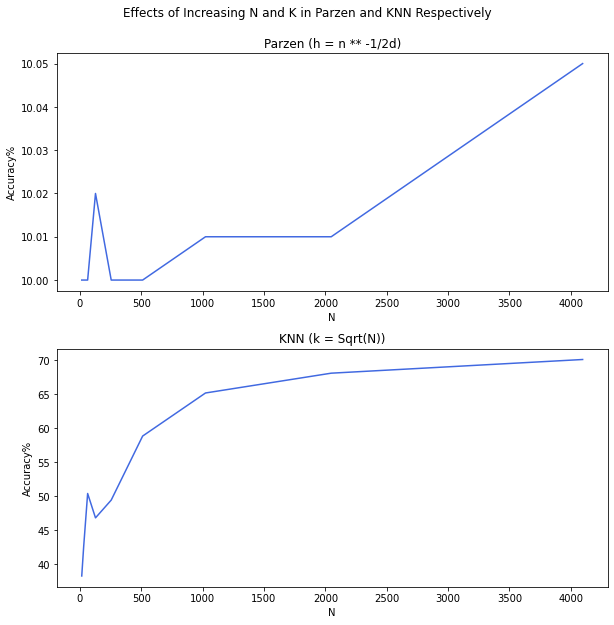

In [ ]:
accs_df = pd.DataFrame(accs)

fig, axes = plt.subplots(2, 1, figsize=(9,9))
ax = axes[0]
ax.plot(
    N, accs_df["parzen"], label="Parzen", color="royalblue"
)
ax.set_title("Parzen (h = n ** -1/2d)")
ax.set_xlabel("N")
ax.set_ylabel("Accuracy%")

ax = axes[1]
ax.plot(
    N, accs_df["knn"], label="KNN", color="royalblue"
)

ax.set_title("KNN (k = Sqrt(N))")
ax.set_xlabel("N")
ax.set_ylabel("Accuracy%")

fig.suptitle("Effects of Increasing N and K in Parzen and KNN Respectively")    
plt.tight_layout(
    rect=(0.02,0.02, 0.98, 0.95)
)

# Q9

### Implementations

In [ ]:
class BaseSelection:
  def __init__(self, k):
    self.k = k
    self.clf = GaussianNB()
    self.selected_indices = None

  def fit(self, X, y, X_test, y_test):
    pass

class ForwardSelection(BaseSelection):
  def fit(self, X, y, X_test, y_test):
    self.selected_indices = []
    self.rmse = []
    while len(self.selected_indices) < self.k:
      best_indice = 0
      best_acc = -np.inf
      curr_sse = 0
      for i in range(X.shape[1]):
        union = sorted(self.selected_indices + [best_indice])
        self.clf.fit(X[..., union], y)
        preds = self.clf.predict(X_test[..., union])
        acc = (preds == y_test).mean()
        curr_sse += (1 - acc) ** 2
        if best_acc < acc:
          best_acc = acc
          best_indice = i
      self.rmse.append(
          np.sqrt(curr_sse/X.shape[1])
          )
      self.selected_indices.append(best_indice)
    self.selected_indices = sorted(self.selected_indices)

class BackwardSelection(BaseSelection):
  def fit(self, X, y, X_test, y_test):
    self.selected_indices = np.arange(X.shape[1])
    self.rmse = []
    while len(self.selected_indices) > self.k:
      worst_indice = 0
      worst_acc = +np.inf
      curr_sse = 0
      for i in range(X.shape[1]):
        union = sorted(self.selected_indices + [best_indice])
        self.clf.fit(X[..., union], y)
        preds = self.clf.predict(X_test[..., union])
        acc = (preds == y_test).mean()
        curr_sse += (1 - acc) ** 2
        if worst_acc > acc:
          worst_acc = acc
          worst_indice = i
      self.rmse.append(
          np.sqrt(curr_sse/X.shape[1])
          )
      self.selected_indices.remove(worst_indice)
    self.selected_indices = sorted(self.selected_indices)

### Preprocessing

In [ ]:
X_train, y_train = mnist_train["image"].to_numpy(), mnist_train["label"].to_numpy()
X_test, y_test = mnist_test["image"].to_numpy(), mnist_test["label"].to_numpy()

X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])


reducer = Pipeline([
                    ("Scaler", StandardScaler()),
                    # ("PCA", PCA(n_components=0.9))
                    ])

X_train = reducer.fit_transform(X_train)
X_test = reducer.transform(X_test)

print(X_train.shape)

### Q9.A

In [ ]:
k = 40

selector = ForwardSelection(k)
selector.fit(X_train, 
             y_train, 
             X_test, 
             y_test)

print(selector.rmse)

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
(preds == y_test).mean()